I used `train.sh` to train a Convolution Neural Network to map DNA sequence onto observed read depth. Let's look at the predictions that the model made on the training set: 

In [1]:
from train import unpickle 
trained_models_path = '../data/trained_models/01'
train_data, dev_data, train_log = unpickle(trained_models_path)
print 'number of training examples:', len(train_data) 
train_data.head()

number of training examples: 26


,chromosome_number,end,observed_depth,sequence,start,predicted_depth
0,1,10500,294.79,CCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCC...,10200,1.043374
1,1,10800,77.06,TCTGACCTGAGGAGAACTGTGCTCCGCCTTCAGAGTACCACCGAAA...,10500,0.941986
2,1,11100,27.35,CACATGCTAGCGCGTCGGGGTGGAGGCGTGGCGCAGGCGCAGAGAG...,10800,0.918523
3,1,11400,49.95,CTCACGTCACGGTGGCGCGGCGCAGAGACGGGTAGAACCTCAGTAA...,11100,1.094932
4,1,11700,82.31,GCACGCCCACCTGCTGGCAGCTGGGGACACTGCCGGGCCCTCTTGC...,11400,1.073697


In [2]:
print 'number of dev examples:', len(dev_data) 
dev_data.head()

number of dev examples: 7


,chromosome_number,end,observed_depth,sequence,start,predicted_depth
8,1,12900,87.58,GTCTCCCCCCAGGTGTGTGGTGATGCCAGGCATGCCCTTCCCCAGC...,12600,1.022139
9,1,13200,78.17,GGCCTGGCAGAGTCTTTCCCAGGGAAAGCTACAAGCAGCAAACAGT...,12900,0.951643
15,1,15000,83.48,ATTCCCAGTCGTCCTCGTCCTCCTCTGCCTGTGGCTGCTGCGGTGG...,14700,1.077754
17,1,15600,86.95,GGCAGCTTGCCTGGGGTCACAGAGCAAGGCAAAAGCAGCGCTGGGT...,15300,0.994680
19,1,16200,20.85,TGGCCAGCCACCGGAGGGGTCAACCACTTCCCTGGGAGCTCCCTGG...,15900,1.015323


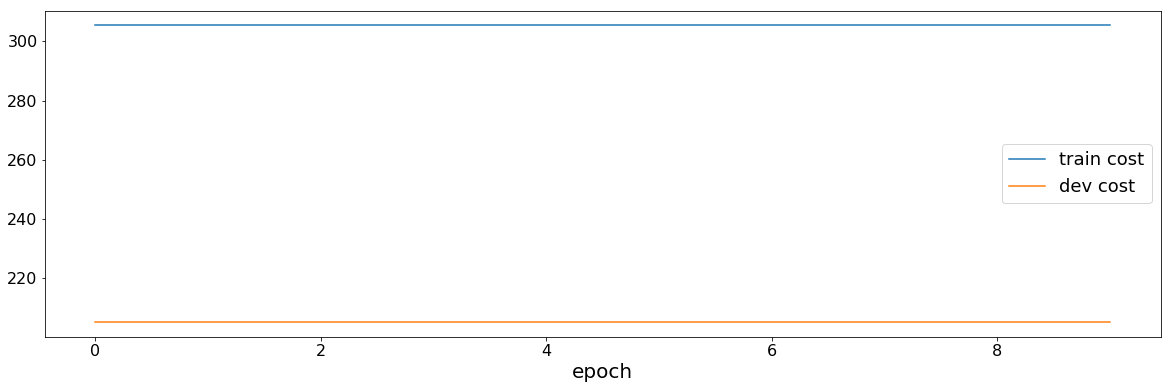

In [3]:
from plot import plot_costs
plot_costs(train_log)

Optional: Visualize the `tensorflow` computation graph and training metrics by executing 

```bash
tensorboard --logdir=$trained_models_path'/tensorboard'
```

and then [clicking here](http://localhost:6006). 

Compare the corrected depth profile (observed depth divided by predicted depth) with the normalized depth profile (observed depth divided by their mean): 

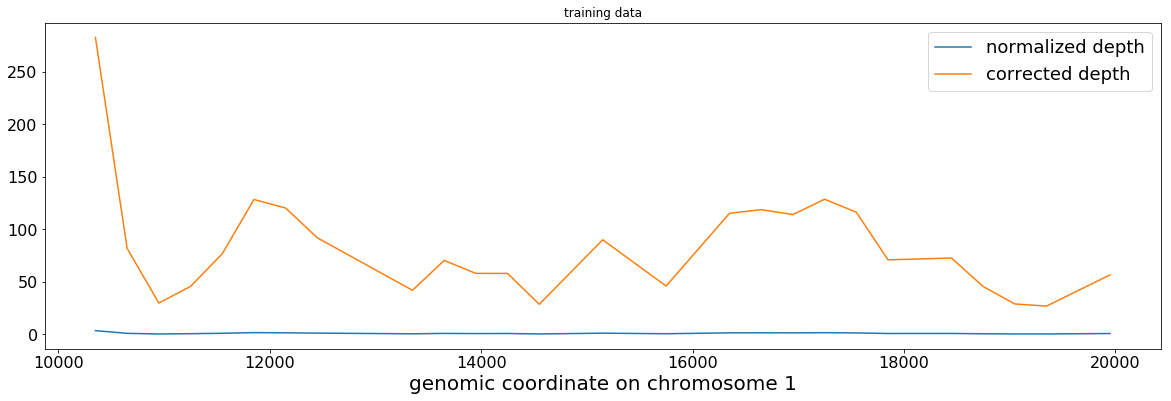

In [4]:
%matplotlib inline 
from plot import plot_corrected_depths, compute_observed_depth_mean

observed_depth_mean = compute_observed_depth_mean(train_data)

plot_corrected_depths(train_data, observed_depth_mean, title='training data')

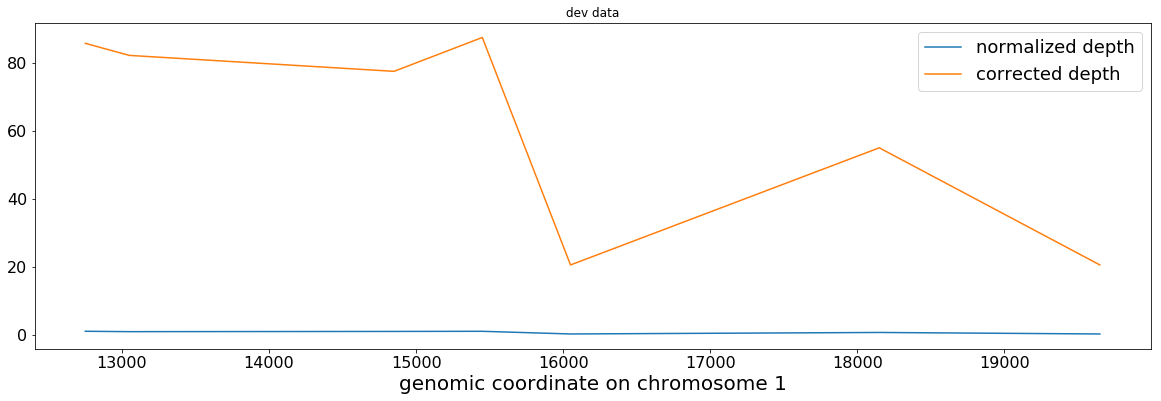

In [5]:
plot_corrected_depths(dev_data, observed_depth_mean, title='dev data')

By running `test.sh`, I used the trained model to make predictions on an independent test set containing a chromosomal deletion: 

In [6]:
from test import unpickle 
test_data = unpickle(trained_models_path)
test_data.head()

,chromosome_number,end,observed_depth,sequence,start,predicted_depth
0,1,189654300,51.12,TCTTATTAGCAAGAAAAAAAAAATACCAGCAAAAGGTTGTAAAACA...,189654000,0.949916
1,1,189654600,50.34,TGCCTAGAATCTGATCTGTTCAGAAAGCAGACAGCAGTTGTTAGAT...,189654300,1.071969
2,1,189654900,47.85,ATTGGAGCTGTAGTAGCCATCCTGACACCATGAGGAGAAGTTTTGA...,189654600,0.969929
3,1,189655200,52.90,GAAAATTCAAGTTAGTAAATTCTTAAAAACTTTCTCTTTCTTCCTG...,189654900,0.972875
4,1,189655500,49.91,CGTATTATTGCTTCTATTAATGTTGTTCACTATTTACCAAATGTAA...,189655200,1.039611


Visually inspect the generalization performance of the prediction algorithm on the test set:

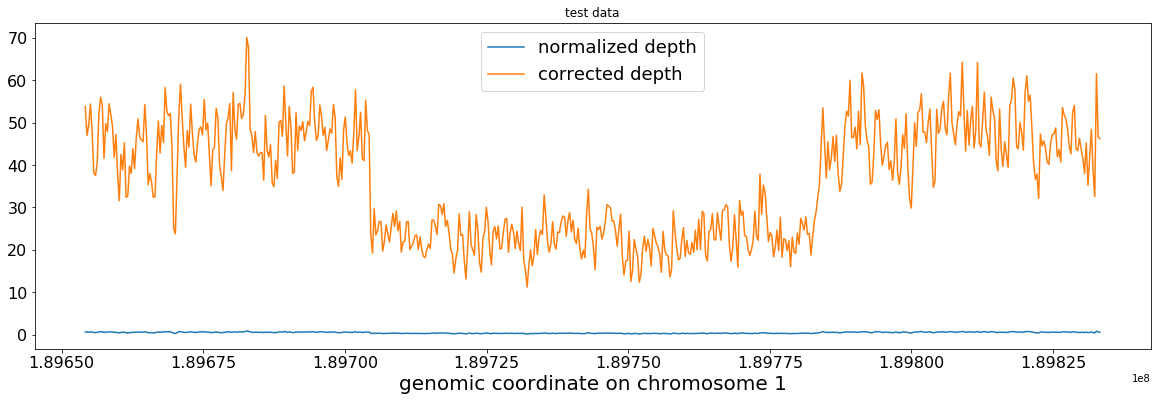

In [7]:
plot_corrected_depths(test_data, observed_depth_mean, title='test data')